In [ ]:
##The dataset is loaded to your GDrive so need to be mounted
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/Satellite Project/')

Mounted at /content/drive


In [ ]:
START_IDX = 0
saved_model_name = 'siamese.pt'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR

import os
import gc
from tqdm import tqdm

from utils import *
from models.siam_nested_unet import Siam_NestedUNet_Conc
from datasets.dataset import ChangeDetectionDataset

## Read Data


In [ ]:
training_path = './trainval/'

In [ ]:
after_images = read_data(training_path, 'after',START_IDX)
before_images = read_data(training_path,'before',START_IDX)
labels = read_data(training_path,'label',START_IDX)

Time taken to read  after  images: 205.52 seconds
Time taken to read  before  images: 219.52 seconds
Time taken to read  label  images: 181.92 seconds


In [ ]:
# diff_images = read_data(training_path,'diff',START_IDX)
# labels = read_data(training_path,'label',START_IDX)

In [ ]:
print(len(before_images))
print(len(after_images))
print(len(labels))

4868
4868
4868


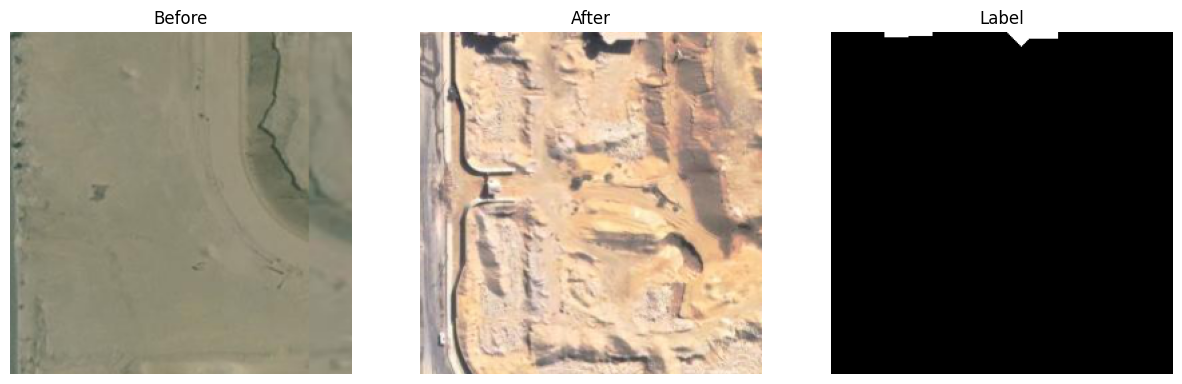

In [ ]:
index = 0
display_images([before_images[index], after_images[index]], labels[index])

## Create Datasets


In [ ]:
batch_size = 16
train_val_ratio = 0.8

In [ ]:
# Define transformations
transform_rgb = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_label = transforms.Compose([
    transforms.ToTensor(),
])

# Assuming you have instantiated your dataset like this
dataset = ChangeDetectionDataset(before_images, after_images, labels, transform_rgb, transform_label)

# Define the indices for train and validation sets
train_size = int(train_val_ratio * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define data loaders for train and validation sets
train_loader = DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle = True)
val_loader = DataLoader(dataset = val_dataset, batch_size=batch_size, shuffle = True)

In [ ]:
del before_images
del after_images
del labels
gc.collect()

9

In [ ]:
print("Percentage of pure black masks in training set:", count_pure_black_masks(train_loader))
print("Percentage of pure black masks in validation set:", count_pure_black_masks(val_loader))

Percentage of pure black masks in training set: 66.17873651771957
Percentage of pure black masks in validation set: 67.24845995893224


In [ ]:
print("Train size:", len(train_loader) * batch_size)
print("Validation size:", len(val_loader) * batch_size)

Train size: 3904
Validation size: 976


In [ ]:
before_images, after_images, label = train_dataset[0]
print(before_images.shape)
print(after_images.shape)
print(label.shape)

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


In [ ]:
# Create an instance of the model, label_nbr
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Siam_NestedUNet_Conc(in_ch=3, out_ch=1).to(device)
criterion = nn.BCEWithLogitsLoss()
print(device)

cuda


In [ ]:
learning_rate = 0.0000002
threshold = 0.3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.2)

In [ ]:
# from torchsummary import summary
# summary(model,input_size=[(3,256,256),(3,256,256)])

## Train Model


In [ ]:
def train_model(model, device, train_loader, criterion, optimizer, scheduler, num_epochs=50, save_dir="saved_models"):
    n_steps = len(train_loader)
    jaccard_loss = 0
    best_jaccard_score = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_iou = 0.0

        predicted_masks_list = []
        true_masks_list = []
        for data in tqdm(train_loader):
            before_image, after_image, true_masks = data
            before_image = before_image.to(device)
            after_image = after_image.to(device)
            true_masks = true_masks.to(device)

            optimizer.zero_grad()
            masks_pred = model(before_image, after_image)  # Pass both before and after images to the model
            loss = criterion(masks_pred, true_masks)
            loss += 0.6 * jaccard_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            pred_masks = (masks_pred > threshold).float()

            for i, pred_mask in enumerate(pred_masks):
                pred_mask = pred_mask.squeeze().cpu().numpy()
                predicted_masks_list.append(pred_mask)

                true_mask = true_masks[i].squeeze().cpu().numpy()
                true_masks_list.append(true_mask)

            # Clearing unnecessary variables from GPU memory
            del before_image, true_masks, masks_pred, loss

        epoch_iou, overall_accuracy = evaluate(predicted_masks_list, true_masks_list)
        epoch_loss = running_loss / n_steps
        jaccard_loss = 1 - epoch_iou

        print(f'Epoch [{epoch + 1}/{num_epochs}] Finished, Loss: {epoch_loss:.5f}, Jaccard Index: {epoch_iou*100:.3f}%, Accuracy: {overall_accuracy*100:.3f}%, Learning Rate: {optimizer.param_groups[0]["lr"]}')
        # Step the scheduler based on the validation IoU
        scheduler.step()

        model_path = os.path.join(save_dir, saved_model_name)
        if epoch_iou > best_jaccard_score:
            best_jaccard_score = epoch_iou
            print(f'Best Jaccard Index: {best_jaccard_score*100:.5f}%')
            torch.save(model.state_dict(), model_path)

        running_loss = 0.0

In [ ]:
# Train the model
train_model(model, device, train_loader, criterion, optimizer, scheduler, num_epochs=20, save_dir= "saved_models")

100%|██████████| 244/244 [05:16<00:00,  1.30s/it]


Epoch [1/20] Finished, Loss: 0.05092, Jaccard Index: 84.136%, Accuracy: 97.938%, Learning Rate: 0.0001
Best Jaccard Index: 84.13575%


100%|██████████| 244/244 [05:17<00:00,  1.30s/it]


Epoch [2/20] Finished, Loss: 0.11057, Jaccard Index: 84.334%, Accuracy: 98.049%, Learning Rate: 0.0001
Best Jaccard Index: 84.33377%


100%|██████████| 244/244 [05:16<00:00,  1.30s/it]


Epoch [3/20] Finished, Loss: 0.10745, Jaccard Index: 84.954%, Accuracy: 98.155%, Learning Rate: 0.0001
Best Jaccard Index: 84.95396%


100%|██████████| 244/244 [05:16<00:00,  1.30s/it]


Epoch [4/20] Finished, Loss: 0.10166, Jaccard Index: 85.910%, Accuracy: 98.284%, Learning Rate: 0.0001
Best Jaccard Index: 85.90995%


100%|██████████| 244/244 [05:16<00:00,  1.30s/it]


Epoch [5/20] Finished, Loss: 0.09602, Jaccard Index: 86.036%, Accuracy: 98.362%, Learning Rate: 0.0001
Best Jaccard Index: 86.03633%


100%|██████████| 244/244 [05:16<00:00,  1.30s/it]


Epoch [6/20] Finished, Loss: 0.09288, Jaccard Index: 87.246%, Accuracy: 98.463%, Learning Rate: 0.0001
Best Jaccard Index: 87.24586%


100%|██████████| 244/244 [05:17<00:00,  1.30s/it]


Epoch [7/20] Finished, Loss: 0.08456, Jaccard Index: 87.814%, Accuracy: 98.609%, Learning Rate: 0.0001
Best Jaccard Index: 87.81388%


100%|██████████| 244/244 [05:17<00:00,  1.30s/it]


Epoch [8/20] Finished, Loss: 0.07768, Jaccard Index: 89.692%, Accuracy: 98.796%, Learning Rate: 2e-05
Best Jaccard Index: 89.69226%


100%|██████████| 244/244 [05:16<00:00,  1.30s/it]


Epoch [9/20] Finished, Loss: 0.06828, Jaccard Index: 90.059%, Accuracy: 98.874%, Learning Rate: 2e-05
Best Jaccard Index: 90.05898%


100%|██████████| 244/244 [05:16<00:00,  1.30s/it]


Epoch [10/20] Finished, Loss: 0.06621, Jaccard Index: 90.267%, Accuracy: 98.893%, Learning Rate: 2e-05
Best Jaccard Index: 90.26705%


100%|██████████| 244/244 [05:16<00:00,  1.30s/it]


Epoch [11/20] Finished, Loss: 0.06450, Jaccard Index: 90.594%, Accuracy: 98.932%, Learning Rate: 2e-05
Best Jaccard Index: 90.59375%


100%|██████████| 244/244 [05:16<00:00,  1.30s/it]


Epoch [12/20] Finished, Loss: 0.06306, Jaccard Index: 90.540%, Accuracy: 98.939%, Learning Rate: 2e-05


100%|██████████| 244/244 [05:16<00:00,  1.30s/it]


Epoch [13/20] Finished, Loss: 0.06329, Jaccard Index: 90.615%, Accuracy: 98.944%, Learning Rate: 2e-05
Best Jaccard Index: 90.61473%


100%|██████████| 244/244 [05:17<00:00,  1.30s/it]


Epoch [14/20] Finished, Loss: 0.06172, Jaccard Index: 91.045%, Accuracy: 98.985%, Learning Rate: 2e-05
Best Jaccard Index: 91.04515%


100%|██████████| 244/244 [05:16<00:00,  1.30s/it]


Epoch [15/20] Finished, Loss: 0.05924, Jaccard Index: 91.439%, Accuracy: 99.019%, Learning Rate: 4.000000000000001e-06
Best Jaccard Index: 91.43945%


 79%|███████▉  | 193/244 [04:11<01:06,  1.30s/it]

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# # Load the latest saved model
model = load_model(model, save_dir="saved_models", model_name=saved_model_name)

## Validate Model


In [ ]:
before_images_list, after_images_list, predicted_masks_list, true_masks_list = validate(model, val_loader, device, threshold)

In [ ]:
jaccard, overall_accuracy = evaluate(predicted_masks_list, true_masks_list)
print("Validation")
print(f"Mean Jaccard Index :{jaccard*100:.5f}%")
print(f"Overall Accuracy :{overall_accuracy*100:.5f}%")

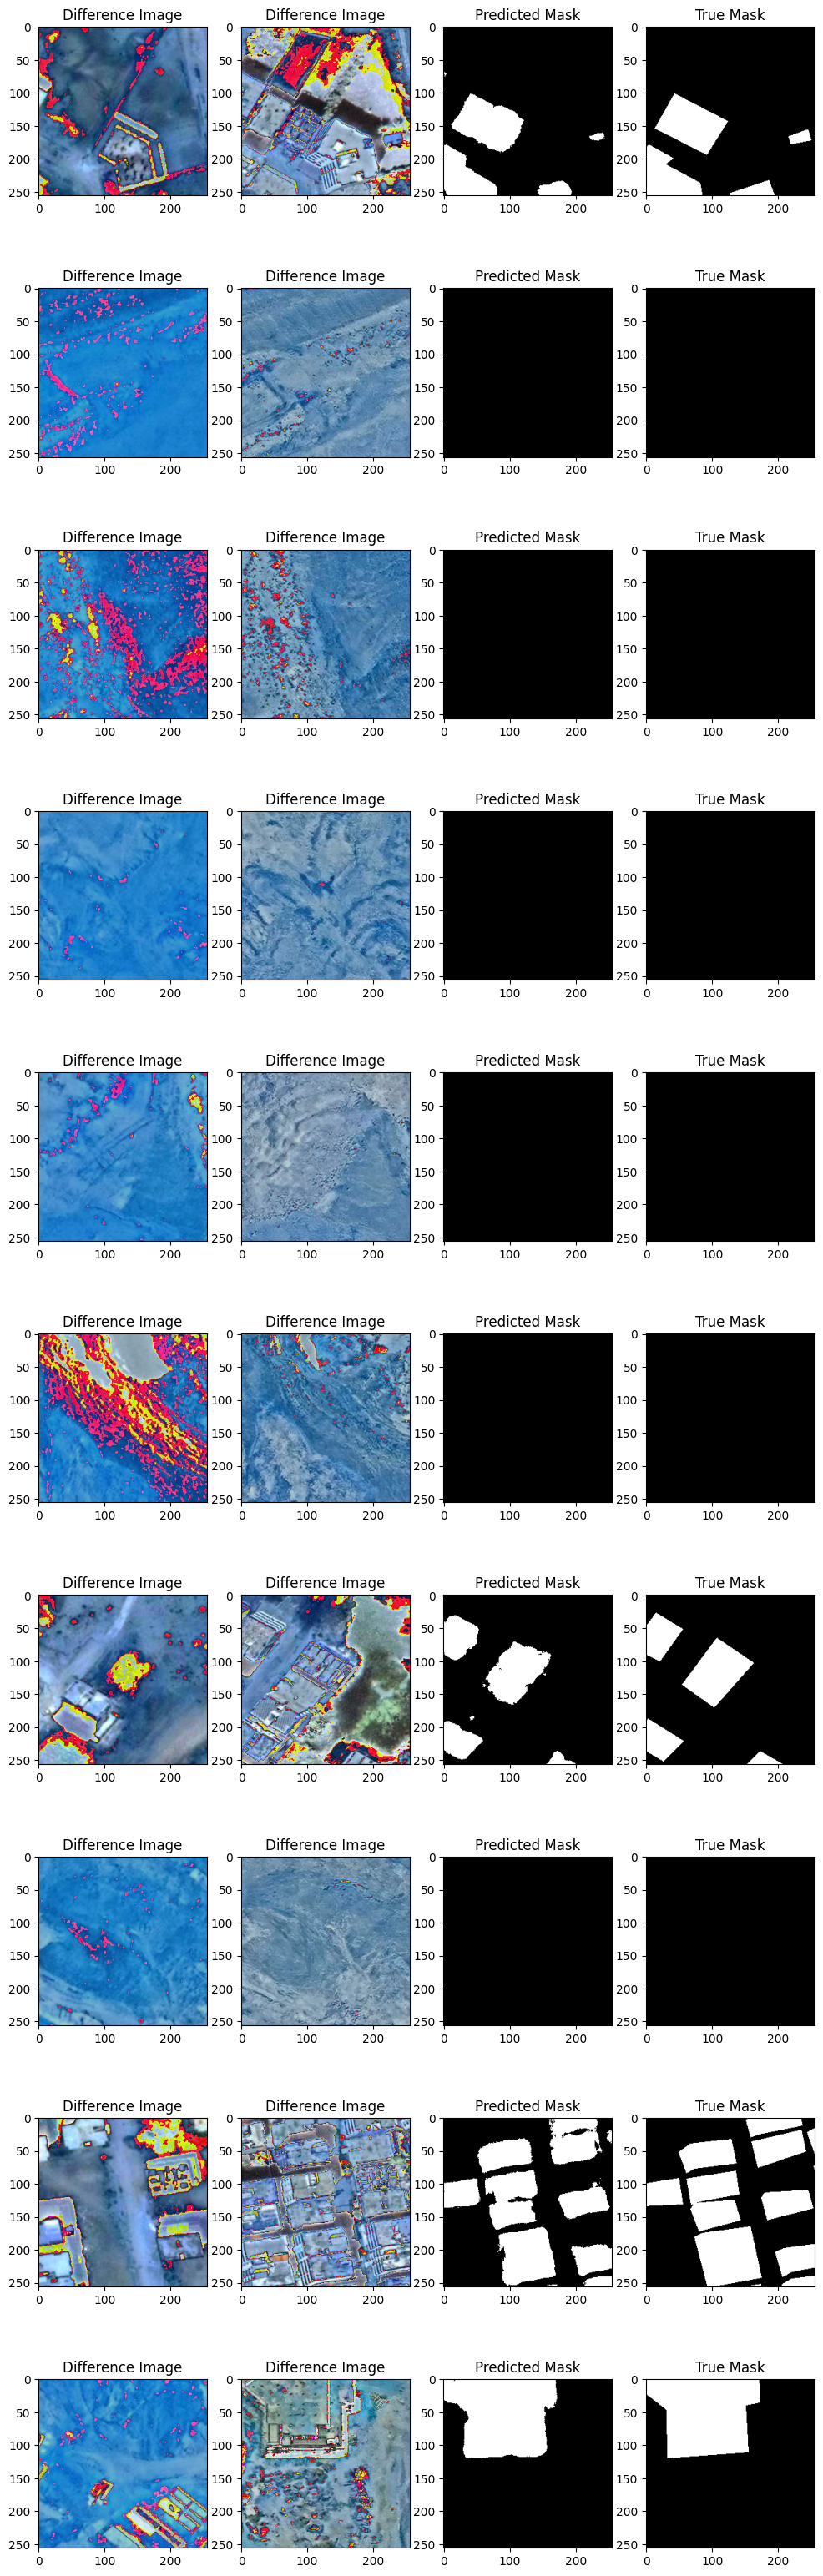

In [ ]:
display_predicted_images(before_images_list, after_images_list, predicted_masks_list, true_masks_list)

In [ ]:
# save_predictions(predicted_masks_list, predicted_images_dir)